# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>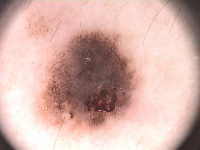</td><td>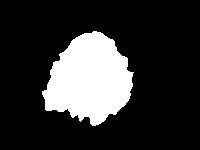</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [12]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-08-01 13:26:08--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-08-01 13:26:08--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce444154b7f03ed17e758ecbca4.dl.dropboxusercontent.com/cd/0/inline/A8orQ729zlqsaabVJVEUDcEUMFNMygsJcIXczeay2GpfkG9sLFNJqb8p-GY4s5FN-fo31kb-azxnAP1jYGnb0698WRGzaqL8FjBszGpqxh3q2w/file# [following]
--2020-08-01 13:26:08--  https://uce444154b7f03ed17e758ecbca4.dl.dropboxusercontent.com/cd/0/inline/A8orQ729zlqsaabVJVEUDcEUMFNMygsJcIXczeay2GpfkG9sLFNJqb8p-GY4s5FN-fo31kb-azxnAP1jYGnb0698WRGzaqL8FjBszGpqxh3q2w/file
Resolving uce

In [13]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [14]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [15]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [16]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [17]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

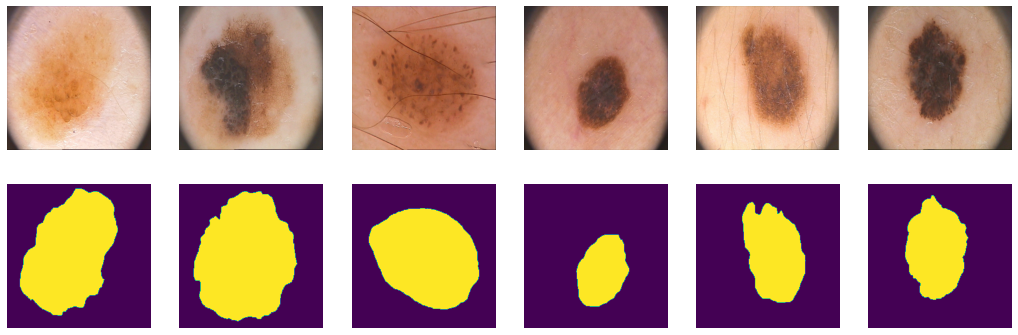

In [18]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [19]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [20]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [21]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [22]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

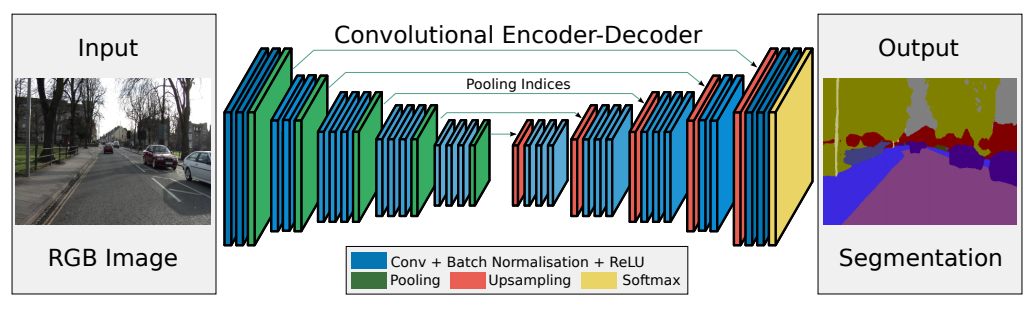

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [145]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        bn_moment = 0.2
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn0 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool0 =  nn.MaxPool2d(3, 2, padding=1) # 256 -> 128
        
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)
        self.bottle_bn = nn.BatchNorm2d(64, momentum=bn_moment)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_bn0 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottle_bn(self.bottleneck_conv(e3)))

        # decoder
        d0 = F.relu(self.dec_bn0(self.dec_conv0(self.upsample0(b))))
        d1 = F.relu(self.dec_bn1(self.dec_conv1(self.upsample1(d0))))
        d2 = F.relu(self.dec_bn2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.upsample3(d2))
        # no activation
        return d3

In [146]:
SegNet()(torch.rand(3, 3, 256, 256)).size()

torch.Size([3, 1, 256, 256])

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [147]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [148]:
def bce_loss(y_real, y_pred):
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [149]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print(f"* Epoch {epoch+1}/{epochs}")

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            # forward-pass
            loss = loss_fn(Y_batch, Y_pred)
            # backward-pass
            loss.backward()
            # update weights
            opt.step()
            # calculate loss to show the user
            avg_loss += loss/len(data_tr)
        toc = time()
        # show intermediate results
        print(f"loss: {avg_loss}")
        # testing mode
        model.eval()
        X_val = X_val.to(device)
        with torch.no_grad():
            # detach and put into cpu
            Y_hat = torch.sigmoid(model(X_val)).cpu()
        X_val = X_val.cpu()
        val_loss = loss_fn(Y_val, Y_hat)
        print(f"val loss: {val_loss}")    
        
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f"{epoch+1}/{epochs} - loss: {avg_loss}, val_los: {val_loss}")
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [150]:
@torch.no_grad()
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.sigmoid(model(X_batch.to(device))).cpu() for X_batch, _ in data]
    return Y_pred.numpy()

In [151]:
@torch.no_grad()
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

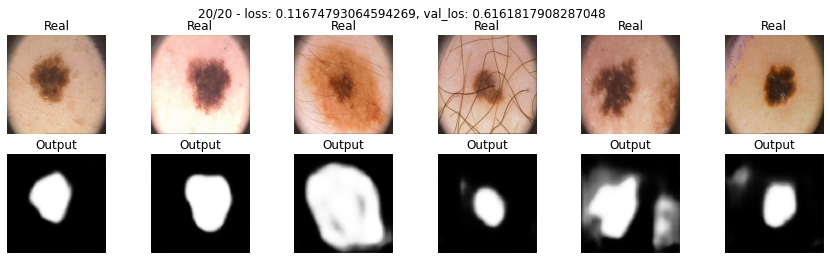

In [152]:
model = SegNet().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [153]:
score_model(model, iou_pytorch, data_val)

0.7139999866485596

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


Проводим тестирование:

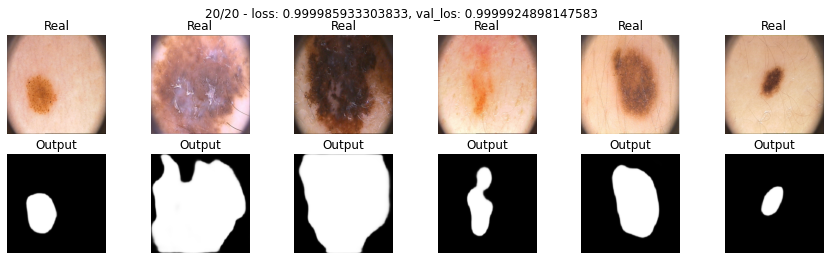

In [154]:
def dice_loss(y_real, y_pred):
  smooth = 1.    
  size = 256

  y_pred = F.sigmoid(y_pred)
  num = 2. * torch.sum(y_real * y_pred)
  den =  torch.sum(y_real + y_pred)
  dice = (num + smooth)/(den + smooth)  

  return 1 - dice / (size * size)

model_dice = SegNet().to(device)

max_epochs = 20
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [155]:
score_model(model_dice, iou_pytorch, data_val)

0.6839999854564667

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [156]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    pred_proba = torch.sigmoid(y_pred).clamp(min=eps, max=(1-eps))
    loss = ((1 - pred_proba) ** gamma) * y_real * torch.log(pred_proba) + (1-y_real) * torch.log(1 - pred_proba)
    return -torch.mean(loss)


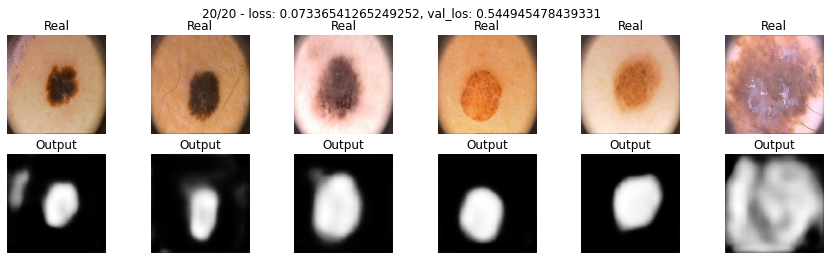

In [157]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [158]:
score_model(model_focal, iou_pytorch, data_val)

0.6839999854564667

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

$$D(X,Y)=\frac{|XY|}{|XY|+\alpha|X/Y| + \beta|Y/X|}$$

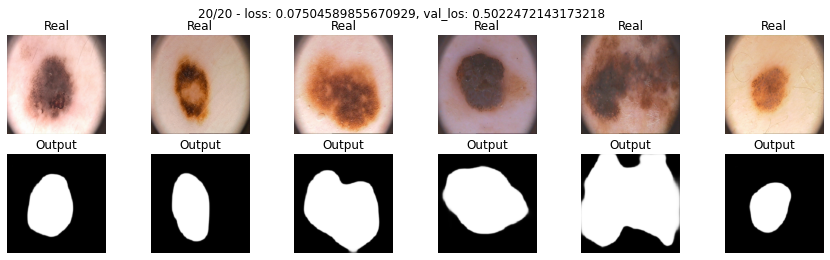

In [159]:
def tversky_loss(y_real, y_pred, alpha=0.4, beta=0.7):
    SMOOTH = 1.0
    
    y_pred = F.sigmoid(y_pred)       

    tp = torch.sum(y_pred * y_real)
    fp = torch.sum((1-y_real) * y_pred)
    fn = torch.sum(y_real * (1-y_pred))

    Tversky = (tp + SMOOTH) / (tp + alpha*fp + beta*fn + SMOOTH)

    return 1 - Tversky

model_tversky = SegNet().to(device)

max_epochs = 20
optimaizer = optim.Adam(model_tversky.parameters())
train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [160]:
score_model(model_tversky, iou_pytorch, data_val)

0.695999950170517

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

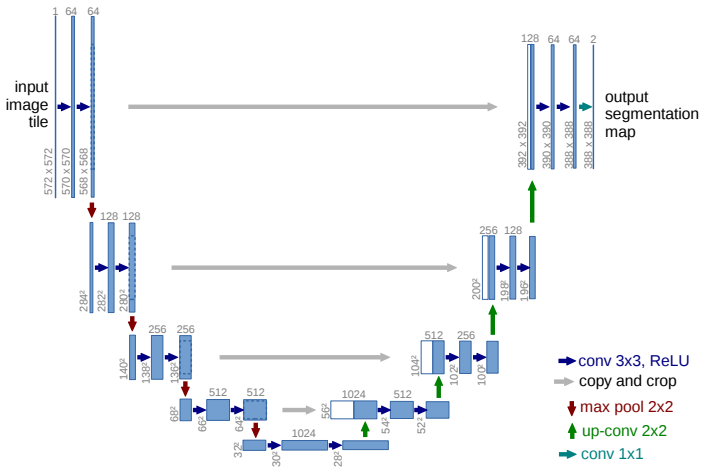

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [161]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        bn_moment = 0.2
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn0 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool0 =  nn.MaxPool2d(3, 2, padding=1) # 256 -> 128
        
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)
        self.bottle_bn = nn.BatchNorm2d(64, momentum=bn_moment)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64+64, 64, 3, padding=1)
        self.dec_bn0 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64+64, 64, 3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64+64, 64, 3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64+64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottle_bn(self.bottleneck_conv(e3)))

        # decoder
        b_cated = torch.cat([b, e3], dim=1)
        d0 = F.relu(self.dec_bn0(self.dec_conv0(self.upsample0(b_cated))))
        
        d0_cated = torch.cat([d0, e2], dim=1)
        d1 = F.relu(self.dec_bn1(self.dec_conv1(self.upsample1(d0_cated))))
        
        d1_cated = torch.cat([d1, e1], dim=1)
        d2 = F.relu(self.dec_bn2(self.dec_conv2(self.upsample2(d1_cated))))
        
        d2_cated = torch.cat([d2, e0], dim=1)
        d3 = self.dec_conv3(self.upsample3(d2_cated))
        # no activation
        return d3

In [162]:
UNet()(torch.rand(1, 3, 256, 256)).size()

torch.Size([1, 1, 256, 256])

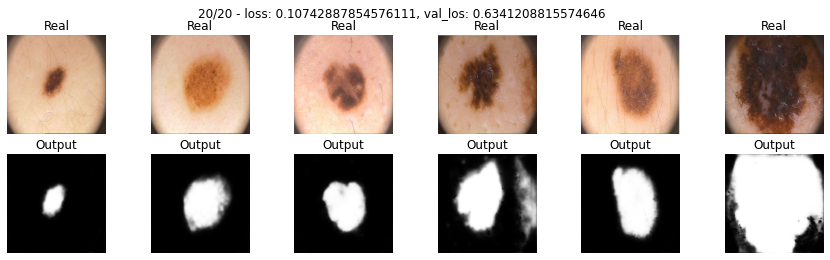

In [163]:
unet_model = UNet().to(device)

train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [164]:
score_model(unet_model, iou_pytorch, data_val)

0.6699999868869781

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [165]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        bn_moment = 0.2
        # encoder
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_bn0 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.enc_pool0 = nn.Conv2d(64, 64, 3, stride=2, padding=1)  # 256 -> 128

        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.enc_pool1 = nn.Conv2d(64, 64, 3, stride=2, padding=1)  # 128 -> 64

        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.enc_pool2 = nn.Conv2d(64, 64, 3, stride=2, padding=1)  # 64 -> 32

        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.enc_pool3 = nn.Conv2d(64, 64, 3, stride=2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)
        self.bottle_bn = nn.BatchNorm2d(64, momentum=bn_moment)

        # decoder
        self.dec_upsample0 = nn.ConvTranspose2d(64+64, 64, 2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_bn0 = nn.BatchNorm2d(64, momentum=bn_moment)

        self.dec_upsample1 = nn.ConvTranspose2d(64+64, 64, 2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64, momentum=bn_moment)

        self.dec_upsample2 = nn.ConvTranspose2d(64+64, 64, 2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(64, momentum=bn_moment)

        self.dec_upsample3 = nn.ConvTranspose2d(64+64, 64, 2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self,x):
        # encoder
        e0 = self.enc_pool0(F.relu(self.enc_bn0(self.enc_conv0(x))))
        e1 = self.enc_pool1(F.relu(self.enc_bn1(self.enc_conv1(e0))))
        e2 = self.enc_pool2(F.relu(self.enc_bn2(self.enc_conv2(e1))))
        e3 = self.enc_pool3(F.relu(self.enc_bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottle_bn(self.bottleneck_conv(e3)))

        # decoder
        b_cated = torch.cat([b, e3], dim=1)
        d0 = F.relu(self.dec_bn0(self.dec_conv0(self.dec_upsample0(b_cated))))

        d0_cated = torch.cat([d0, e2], dim=1)
        d1 = F.relu(self.dec_bn1(self.dec_conv1(self.dec_upsample1(d0_cated))))
        
        d1_cated = torch.cat([d1, e1], dim=1)
        d2 = F.relu(self.dec_bn2(self.dec_conv2(self.dec_upsample2(d1_cated))))
        
        d2_cated = torch.cat([d2, e0], dim=1)
        d3 = self.dec_conv3(self.dec_upsample3(d2_cated))
        # no activation
        return d3

In [166]:
UNet2()(torch.rand(1, 3, 256, 256)).size()

torch.Size([1, 1, 256, 256])

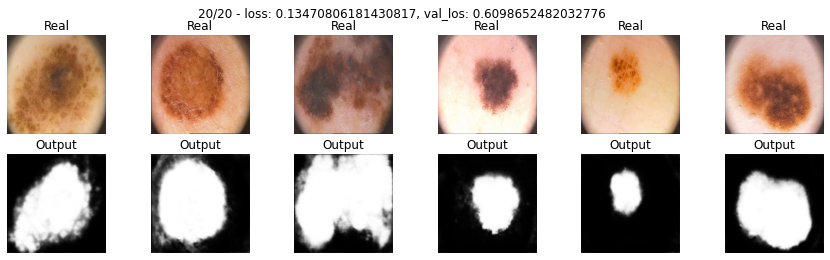

In [167]:
unet2_model = UNet2().to(device)

train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 20, data_tr, data_val)

In [168]:
score_model(unet2_model, iou_pytorch, data_val)

0.6499999463558197

In [169]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [170]:
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()

        bn_moment = 0.2
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1, dilation=1)
        self.bn0 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool0 =  nn.MaxPool2d(3, 2, padding=1) # 256 -> 128
        
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=2, dilation=2)
        self.bn1 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=3, dilation=3)
        self.bn2 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=4, dilation=4)
        self.bn3 = nn.BatchNorm2d(64, momentum=bn_moment)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=4, dilation=4)
        self.bottle_bn = nn.BatchNorm2d(64, momentum=bn_moment)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=4, dilation=4)
        self.dec_bn0 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=3, dilation=3)
        self.dec_bn1 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=2, dilation=2)
        self.dec_bn2 = nn.BatchNorm2d(64, momentum=bn_moment)
        
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1, dilation=1)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256

    def forward(self, x):
        # encoder

        e0 = self.pool0(F.relu(self.bn0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottle_bn(self.bottleneck_conv(e3)))

        # decoder
        d0 = F.relu(self.dec_bn0(self.dec_conv0(self.upsample0(b))))
        d1 = F.relu(self.dec_bn1(self.dec_conv1(self.upsample1(d0))))
        d2 = F.relu(self.dec_bn2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.upsample3(d2))
        # no activation
        return d3



In [171]:
DilatedSegNet().to(device)(torch.rand(1, 3, 256, 256).to(device)).size()

torch.Size([1, 1, 256, 256])

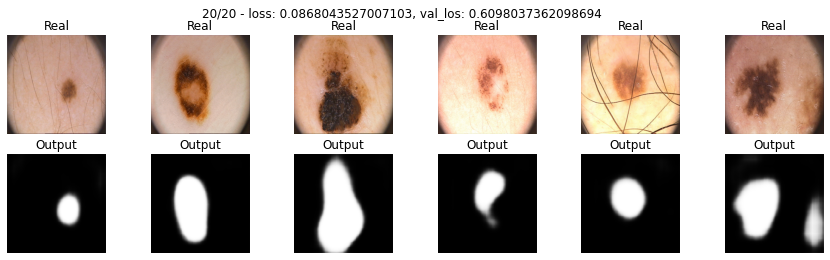

In [172]:
model_dial_signet = DilatedSegNet().to(device)

train(model_dial_signet, optim.Adam(model_dial_signet.parameters()), bce_loss, 20, data_tr, data_val)

In [173]:
score_model(model_dial_signet, iou_pytorch, data_val)

0.6180000007152557

In [174]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

seg_params = count_parameters(model)
unet_params = count_parameters(unet_model)
unet2_params = count_parameters(unet2_model)
dial_seg_params = count_parameters(model_dial_signet)

seg_score = score_model(model, iou_pytorch, data_val)
unet_score = score_model(unet_model, iou_pytorch, data_val)
unet2_score = score_model(unet2_model, iou_pytorch, data_val)
dial_seg_score = score_model(model_dial_signet, iou_pytorch, data_val)

print(f"SegNet has {seg_params} parametrs, and val_score: {seg_score:.4f}")
print(f"DilatedSegNet has {dial_seg_params} parametrs, and val_score: {dial_seg_score:.4f}")
print(f"UNet has {unet_params} parametrs, and val_score: {unet_score:.4f}")
print(f"UNet2 has {unet2_params} parametrs, and val_score: {unet2_score:.4f}")

SegNet has 261889 parametrs, and val_score: 0.7140
DilatedSegNet has 261889 parametrs, and val_score: 0.6180
UNet has 373057 parametrs, and val_score: 0.6700
UNet2 has 540929 parametrs, and val_score: 0.6500


# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

